# Taking Netflix By Storm: The Correlation between Watching and the Weather

TODO:
* Seperate code into utils/project specific
* More Data Aggregation
    * Data dispersion display for each temp category
    * Precipitation Hypo Test
    * A third hypothesis test -- ideas on what to test?   
* Classification
    * kNN
    * kNN comparison
* Conclusion
* Create README.md

## Introduction
### A. The Entertainment Domain
My project will take place in the entertainment domain and deal primarily with my Netflix consumption patterns. Netflix and TV shows in general are certainly prevelant in my daily life. In general, I try to be careful about the amount of time I spend watching Netflix and consuming other digital media in order to ensure that I am not forgetting to live my life and that I am not getting addicted to watching certain shows. The entertainment domain is something that I am continuously aware of and trying to track in my everday life. It is certainly important for society as a whole to be looking into this domain, looking at the factors that impact our consumption within this domain, and reflecting on the impact that this domain has on our lives. I am reasearching this domain because I am particularly interested in finding out if factors outside of this domain, in this case weather, can have a significant impact on how much time we spend within the entertainment domain.  


### B. Hypotheses
My hypothesis about this domain is that I will find a correlation between my Netflix viewing habits and the weather. I believe that when the weather is colder, then my total time watching Netflix is above average. In addition to this, I also believe the opposite. When the weather is warmer, my total time watching netflix is below my average. The impact of these results could help me in the long run as I try to be conscious and limit the amount of time I spend on Netflix. If I am aware that colder weather has an impact on my viewing patterns, it will help me to remember to be more conscious about it on days when the weather is colder. My roommates are also stakeholders in this study due to the fact that I force them to watch Netflix with me in our apartment. If it is true that the weather effects our viewing patterns, then it is effecting my roommates as well as myself. Netflix as a company is also a stakeholder in this. If there are more people using their platform on a given day they need to make sure that everything is running smoothly and quickly. However, on a warmer day when not as many people are watching, it is not as likely that there will be problems on their platform.

## Data Analysis
### A. Dataset Description
The first table that will be used in the dataset is my netflix data table. This table is downloaded from my account on netflix. It is downloaded as a CSV file and contains three different attributes. The first is a categorical, specifically nominal, attribute, it is the name of the TV show/specific episode or movie that I watched. The second is an ordinal attribute, this attribute holds the date that the show or movie was watched. The final attribute for this table is continuous and contains the length of the show or movie that I watched. This attribute was added manually by me after the data was downloaded.  
The second table that I want to join with the first is a data from a weather.gov website. This dataset is a csv file downloaded from an government website: https://w2.weather.gov/climate/xmacis.php?wfo=otx. There are three attributes that I will focus on. The first attribute is the date, this is the attribute that I plan to use as the key to merge the two datasets together. The second attribute is an interval attribute and will describe the temperature in degrees fahrenheit for that date. The third and fourth attributes are ratio attributes, with the third holding the amount of precipitatio/snowfall for each date in the table.

### B. Data Preparation
Both data sets will be loaded in from their respective csv files in order to begin the data cleaning process.

In [156]:
import pandas as pd
import numpy as np
import py_utils

#load in netflix viewing data
viewing_df = py_utils.load_data("netflix_viewing_data.csv")

Both data sets will need to be cleaned before they can be merged. In the weather dataset, the precipitation column will be cleaned by replacing the amount of precipitation with either a 0 or a 1 depending on whether or not there was precipitation on a given day.  

In addition to this, the median temperature was found and used to create another category, "Temp Category". If the high on a given date is above or equal to the median (73), the date is given a "High" label in the "Temp Category". If the high on a given date is below the median (73), the date is given a "Low" label in the "Temp Category".

In [157]:
# load in weather data from MeteoStat API
import requests
import json

api_key = "x4OYeAd2RgfD0XS6d6it41PRdVLdPE5C"

# meteostat API requires your API key be in the request headers, not in the url query params
headers = {"x-api-key": api_key}

# step 1: get the spokane weather station
url = "https://api.meteostat.net/v2/stations/search"
# add query params
url += "?query=spokane"

response = requests.get(url=url, headers=headers)
json_object = json.loads(response.text)
data_object = json_object["data"][0]
spokane_id = data_object["id"]


# step #2: use spokane weather station id to get daily weather for all of 2020
url = "https://api.meteostat.net/v2/stations/daily"
# add query params
url += "?station="
url += spokane_id
url += "&start=2020-08-29"
url += "&end=2020-10-30"

response = requests.get(url=url, headers=headers)
json_object = json.loads(response.text)

In [159]:
import pandas as pd

# create the necessary pandas object to hold the data
data_object = json_object["data"]
#weather_df = py_utils.load_weather(data_object)

weather_df = pd.DataFrame()
tmax_ser = pd.Series(dtype=float)
prec_ser = pd.Series(dtype=float)

# load in the data 
for date_object in data_object:
    date = date_object["date"]
    tmax = date_object["tmax"] * (9 / 5) + 32 #convert to F
    prec = date_object["prcp"]
    snow = date_object["snow"]
    daily_prec = float(prec) + float(snow)
    tmax_ser[date] = tmax
    prec_ser[date] = daily_prec

# put the data into the dataframe
weather_df["tmax"] = tmax_ser
weather_df["prec"] = prec_ser
weather_df["Date"] = prec_ser.index
weather_df.set_index("Date", inplace = True)


In [112]:
#clean precipitation column
precip_ser = weather_df["prec"]

# if rain then 1, if not then 0
for i in range (0, len(precip_ser)):
    if precip_ser[i] > 0:
        precip_ser.replace(precip_ser[i], 1, inplace=True)
weather_df["prec"] = precip_ser

# find median for future split
temp_ser = weather_df["tmax"]
temp_ser.sort_values()
temp_median = temp_ser.median()
print("Median temperature:", temp_median)

# add column to keep track of low/high
temp_ser = weather_df["tmax"] # get the unsorted series
low_high_ser = pd.Series(dtype=int)
for i in range (0, len(temp_ser)):
    if temp_ser[i] < temp_median:
        low_high_ser = low_high_ser.append(pd.Series("Low"))
    elif temp_ser[i] == temp_median or temp_ser[i] > temp_median:
        low_high_ser = low_high_ser.append(pd.Series("High"))
        
weather_df["temp cat"] = low_high_ser.values
weather_df.to_csv("spokane_weather_clean_data.csv")

Median temperature: 73.03999999999999


The netflix dataset also needs to be cleaned. Rather than add the current DataFrame which includes each individual show title and watch time, I will create a new dataframe that only includes the date and the total watch time for that particular date. This new dataframe will be the one merged with the Spokane weather dataframe that was cleaned above. 

In [114]:
date_col = viewing_df["Date"] #get date column
time_col = viewing_df["Length"] #get length column
total_watch_df = pd.DataFrame() #create new df

# create new series to add to df
dates_no_repeats = pd.Series(dtype=int)
total_watch_ser = pd.Series(dtype=int)

# add each date to the dates_no_repeats sereis
for i in range (8, 11):
    for j in range(1,32):
        if i == 8 and j >= 29:
            date_str = "2020-0" + str(i) + "-" + str(j)
            dates_no_repeats = dates_no_repeats.append(pd.Series(date_str))
        elif i == 9:
            if j < 31: 
                if j < 10:
                    date_str = "2020-0" + str(i) + "-0" + str(j)
                else: 
                    date_str = "2020-0" + str(i) + "-" + str(j)
                dates_no_repeats = dates_no_repeats.append(pd.Series(date_str))
        elif i == 10:
            if j < 31: 
                if j < 10:
                    date_str = "2020-" + str(i) + "-0" + str(j)
                else: 
                    date_str = "2020-" + str(i) + "-" + str(j)
                dates_no_repeats = dates_no_repeats.append(pd.Series(date_str))

date_col = dates_no_repeats.values
total_watch_df["Date"] = dates_no_repeats.values # add to the df
date_ser = total_watch_df["Date"] # get the column from the df 

# add 0s to each value in total_watch_ser
for i in range (len(total_watch_df["Date"])):
    total_watch_ser = total_watch_ser.append(pd.Series(0))

total_watch_df["Viewing Time"] = total_watch_ser.values # add to the df
watch_ser = total_watch_df["Viewing Time"].copy() # get the column for use below

# add total times to each date
for i in range(len(date_col)):
    date = date_col[i] # get date from old df
    for j in range(0, len(total_watch_df["Date"])):
        target_date = date_ser[j] # target date from new df
        if date == target_date:
            new_num = watch_ser[j] + time_col[i] # add current value to new value for each date
            watch_ser[j] = new_num # set equal to new value
            #total_watch_df.loc["Viewing time", j] = new_num
            
total_watch_df["Viewing Time"] = watch_ser.values 

Now that the two datasets are cleaned, they need to be merged. In the code cell below, the weather_df that contains the date, tmax, precip, and temp category will be merged with the total_watch_df that contains the date and total viewing time for that date. These two dataframes will be merged on the "Date" category and written to a csv file named "merged_netflix_viewing_weather.csv". 

In [116]:
# join the two datasets together
merged_netflix_weather_df = total_watch_df.merge(weather_df, on="Date")
merged_netflix_weather_df.to_csv("merged_netflix_viewing_weather.csv")

### C. Exploratory Data Analysis
Before moving into more complex data aggregation techniques, I want to first show the initial relationship between the temperature and the number of minutes watched. This will be done directly below using a scatter plot. 

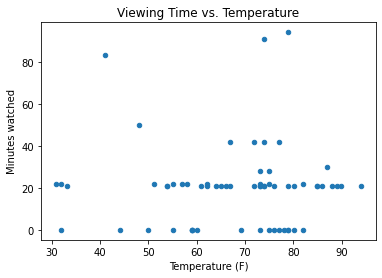

In [117]:
# create a scatter plot showing the initial relationship between the two data sets
import numpy as np
import matplotlib.pyplot as plt

plt.title("Viewing Time vs. Temperature")
plt.scatter(merged_netflix_weather_df["tmax"], merged_netflix_weather_df["Viewing Time"], s=20)
plt.xlabel("Temperature (F)")
plt.ylabel("Minutes watched")
plt.show()

The scatter plot above does not clearly show a relationship between the temperature and the number of minutes watched. In order to get a clearer picture of the meaning behind and the answer to our hypotheses, more data aggregation and relationship tests will need to be computed.

The data will first undergo a split based on the "Temp Category" column. All of the dates with a "Low" category will be gathered into a dataframe while all of the dates with a "High" category will be gathered into a different dataframe. After this, the mean and standard deviation will be calculated for each group.

In [118]:
# split the dataset
low_temp_df = pd.DataFrame()
high_temp_df = pd.DataFrame()
grouped_by_temp_category = merged_netflix_weather_df.groupby("temp cat")
for group_name, group_df in grouped_by_temp_category:
    if group_name == "Low":
        low_temp_df = group_df
    elif group_name == "High":
        high_temp_df = group_df

# find mean viewing time of both groups
viewing_time_low_ser = low_temp_df["Viewing Time"]
viewing_time_high_ser = high_temp_df["Viewing Time"]
print("Mean of low category", viewing_time_low_ser.mean())
print("Mean of high category", viewing_time_high_ser.mean())
print()

# find the standard deviation of each group
print("Standard deviation of low category", viewing_time_low_ser.std())
print("Standard deviation of high category", viewing_time_high_ser.std())

Mean of low category 19.366666666666667
Mean of high category 21.666666666666668

Standard deviation of low category 18.064030430728877
Standard deviation of high category 21.828402751155817


Using the above mean and standard deviation of each temperature category, the confidence intervals will be computed. These confidence intervals will be found at 95%. 

In [119]:
# Find the Confidence Interval at 95%

#low weather 
Xbar_low = viewing_time_low_ser.mean()
std_low = viewing_time_low_ser.std()
n = len(viewing_time_low_ser)
t = 2.000

margin_of_error = t * std_low / np.sqrt(n)
conf_interval_low_temp = (Xbar_low - margin_of_error, Xbar_low + margin_of_error)
print("Low temp confidence interval:", conf_interval_low_temp)

#high weather 
Xbar_high = viewing_time_high_ser.mean()
std_high = viewing_time_high_ser.std()
n = len(viewing_time_high_ser)
t = 2.000

margin_of_error = t * std_high / np.sqrt(n)
conf_interval_high_temp = (Xbar_high - margin_of_error, Xbar_high + margin_of_error)
print("High temp confidence interval:", conf_interval_high_temp)

Low temp confidence interval: (12.770615369086688, 25.962717964246647)
High temp confidence interval: (14.066992298310446, 29.26634103502289)


The confidence intervals for each group have a very large range. In order to better show this relationship, the confidence interval for each will be shown in a graph below. 

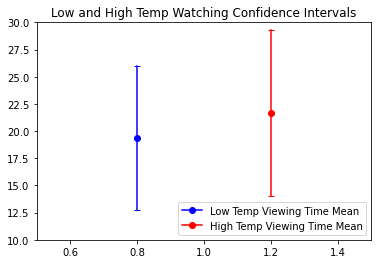

In [120]:
## graph them
plt.figure()
plt.title("Low and High Temp Watching Confidence Intervals")

plt.plot([.8, .8], conf_interval_low_temp, marker="_", color="blue")
plt.plot([.8], [Xbar_low], marker="o", color="blue", label="Low Temp Viewing Time Mean")

plt.plot([1.2, 1.2], conf_interval_high_temp, marker="_", color="red")
plt.plot([1.2], [Xbar_high], marker="o", color="red", label="High Temp Viewing Time Mean")

#set x and y limits
plt.ylim([10, 30])
plt.xlim([0.5, 1.5])
plt.legend(loc='lower right')
plt.show()

As shown in the graph above, the low temp viewing confidence interval is quite large while the high temp confidence interval has a smaller range. However, both ranges are still quite large. At first glance, it appears that the low temp viewing mean could be higher than the high temp viewing mean. This first glance analysis will be the basis of our first hypothesis test. 

### C. Hypothesis Testing
For this particular statistical hypothesis test, a 2 sample, independent, right tailed test to find out if I watched more netflix when the temperature was below 75 degrees (low category) than when the temperature was greater than or equal to 75 degrees (High category). We will be using a significance level of .05.

Step 1:  
$H_0: \mu_1 \leq \mu_2$  
$H_0: \mu_1 > \mu_2$

Step 2:  
$\alpha = .05$

Step 3:  
The appropriate t-test:  
$t = \frac{\overline{x_1} - \overline{x_2}}{\sqrt{S_p^2(\frac{1}{n_1} + \frac{1}{n_2})}}$ 

Step 4:  
Find t-critical:  
* right tailed
* $\alpha = .05$
* ddof = $n_1 + n_2 - 2$ = 31 + 31 - 2 = 60

t-critical = 1.671

Decision rule:  
* If t-computed is > 1.671 then reject $H_0$  
* If t-computed is $leq$ 1.671 then do not reject $H_0$

Step 5:  
t-test:  
$t = \frac{\overline{x_1} - \overline{x_2}}{\sqrt{S_p^2(\frac{1}{n_1} + \frac{1}{n_2})}}$ 

In the code cell below the SciPy method ttest_ind() will be used to compute the above formula:

In [ ]:
import scipy.stats as stats

t_value, p_value = stats.ttest_ind(viewing_time_low_ser.tolist(), viewing_time_high_ser.tolist())
print(t_value)

Since t-computed (.9848) is less than t-critical (1.671):
* Do not reject $H_0$
    * $\mu_1 \leq \mu_2$
* Cannot accept $H_1$
    * $\mu_1 > \mu_2$
    
This conclusion will be checked using the p-value:

In [ ]:
print(p_value / 2)

Since the p-value (.1643) is greater than $\alpha$ (.05), $H_0$ cannot be rejected.

Conclusion: At the .05 level of significance, we can reasonable assume that the mean netflix time watching when the weather is "low" (less that 75 degrees) is less than or equal to the time spent watching when the weather is "high" (greater than or equal to 75 degrees).